# Descriptive Statistics and Hypothesis Testing
## Optional activity
Optional activity for additional learning.

# Descriptive Statistics and Hypothesis Testing
This lab covers the following sections of the lesson 7:

1. Initial setup  
1. Determining Sample Size / Statistical Significance - Formula  
1. Applying confidence intervals to determine if the differences in the populations are significant  
1. Significance, p-value, Type 1 and 2 errors. Use a hypothesis test and its p-values to determine if the differences in the populations are significant  
1. Using Chi-squared distribution for identifying outliers 

## Purpose
Demonstrate an example of descriptive statistics using housing data


## Initial setup:
1. The packages:
 * _readxl_ - reads our data from an Excel spreadsheet
 * _ggplot2_ - plotting
 * _dplyr_ - data manipulation
 * _mvoutlier_ - multivariate outlier handling and plotting
 * _rrcov_ - covariance matrix calculation
 * _chemometrics_ - basic Mahalanobis distance plot
2. Loads AmesHousing.xls

In [1]:
# Load libraries
library(mvoutlier)
library(rrcov)
library(chemometrics)
library(stats) 
library(tidyverse)

Loading required package: sgeostat
sROC 0.1-2 loaded
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.4-4)

Loading required package: rpart
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
# load data
AmesHousing<-readxl::read_excel("AmesHousing.xls")

## Determining Sample Size / Statistical Significance - Formula
$ n=\frac{Z^*\sigma}{m}$
Z* - critical value of the standard normal distribution <br />
if sample size n is small we can use t* with n degrees of freedom, using R function qt(quantile, degrees_of_freedom) <br />
$\sigma$ standard distribution of the population <br />
m - effect or difference between estimated and actual value, note here we are using 1/2 of a total effect (or $\pm$difference value)


In [3]:
# estimating sample size from small sample
set.seed(0)

sample_size <- 10

sample = sample(AmesHousing$SalePrice, sample_size)

xbar <- mean(sample)

#be mindful of the effect, if you are using 2 sided, i.e. 20% - the formula adds multipler 2 to
#the nominator
effect <- xbar*0.05 # +/- 5% of sample mean ~8107

sd <- sd(sample)

sprintf("Estimating statistically sample size from small sample of %d elements ...", sample_size)
sprintf("Sample mean is %10.4f; Standard deviation is %10.4f; 5%% effect is %10.4f", xbar, sd, effect)

#good sample size using normal distribution
good_sample_size <- ((qnorm(.975) * sd)/effect)^2

#better sample size using t distribution to adjust for smaller sample
better_sample_size <- ((qt(.975, sample_size-1) * sd)/effect)^2

sprintf("Recommended size, using normal distribution is %10.4f and using t-distribution is %10.4f", 
                                                        good_sample_size, better_sample_size)

[1] "Estimating statistically sample size from small sample of 10 elements ..."

[1] "Sample mean is 162140.0000; Standard deviation is 48813.3224; 5% effect is  8107.0000"

[1] "Recommended size, using normal distribution is   139.2684 and using t-distribution is   185.5248"

### Mini experiment to see how sample size estimate varies for different sample sizes
**Note: **
1. This is not the most efficient code, but OK for our experiment 
2. We get quite a range of significant sample size estimates because the sample doesn't accurately reflect population's deviation. **Conclusion:** ideally we have population's standard deviation for the most accurate estimate, if we don't - the sample deviation still gives us much better idea of the sample size than a random guess / rule of thumb.
3. After running the experiment - uncomment line: sd <- sd(AmesHousing$SalePrice)


In [4]:
#create an empty 2 column dataframe
good_sample_size <- data.frame(sample_n = integer(0), good_sample_n = numeric(0))

idx <- 0

for(i in seq(from=5, to=length(AmesHousing$SalePrice), by=5))
{
  set.seed(0)
  
  sample_size <- i

  sample = sample(AmesHousing$SalePrice, sample_size)
  
  #what if we use sample standard deviation, instead of standard deviation of distribution
  xbar <- mean(sample)

  sd <- sd(sample)

  #after running this experiment once, uncomment this line 
  #rerun the cell and note the difference in the recommended sample
  #conclusion: to estimate statistical significant size it is better to use standard deviation of the population 
  # sd <- sd(AmesHousing$SalePrice) 
  
  #bind a row with new data to the dataframe
  good_sample_size <- rbind(good_sample_size, data.frame(sample_n = sample_size, good_sample_n = (((qt(.975, sample_size-1) * sd)/effect))^2))
  
  idx <- idx + 1
}

sprintf("Using various sample sizes from 5 to %d to estimate statistical significance sample recommendation",length(AmesHousing$SalePrice))
sprintf("We get a range from %6.0f to %6.0f with an average of %6.0f sample size recommendation", 
        min(good_sample_size$good_sample_n), max(good_sample_size$good_sample_n), mean(good_sample_size$good_sample_n))


[1] "Using various sample sizes from 5 to 2930 to estimate statistical significance sample recommendation"

[1] "We get a range from    118 to    417 with an average of    354 sample size recommendation"

## Applying confidence intervals to determine if the differences in the populations are significant
In this section - we are going to calculate confidence interval for a population mean, first using formula and then using bootstrap.

** Note: **
1. In bootstrap - we are resampling the original sample multiple times.
2. The formula and the bootstrap gave us similar confidence interval. This gives us an additional confidence that our estimates come from data, not a method of estimate

In [5]:
# Calculate population mean with and associated confidence interval using formula
set.seed(0)
sd <- sd(AmesHousing$SalePrice)

sample_size <- 185
sample <- sample(AmesHousing$SalePrice, sample_size)
xbar <- mean(sample)

MOE_N <- qnorm(0.975)*sd/sqrt(sample_size)
MOE_t <- qt(0.975, sample_size-1)*sd(sample)/sqrt(sample_size)

print(paste("Population mean estimate: ", xbar))
print(paste("   with margin of error (normal distribution) +/- ", MOE_N))
print(paste("   with margin of error (t distribution) +/- ", MOE_t))

[1] "Population mean estimate:  178778.545945946"
[1] "   with margin of error (normal distribution) +/-  11511.6258762268"
[1] "   with margin of error (t distribution) +/-  10000.4341291296"


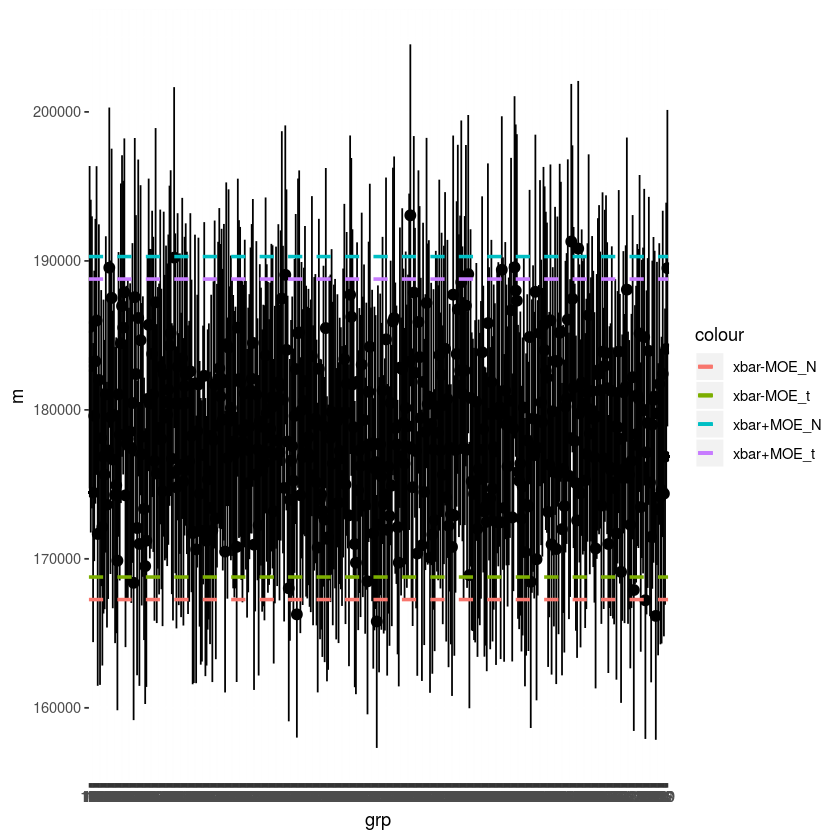

In [6]:
# Calculate population mean using bootstrap
set.seed(0)
sampleMean <- c()
sampleMOE_t  <- c()
random_sample_size <- sample_size
for (i in 1:500)
{
  randomSample <- sample(sample, random_sample_size, replace=TRUE)
  
  #calculate and save random sample average 
  sampleMean[i] <- mean(randomSample)
  
  #calculate and save sample MOE_t
  sampleMOE_t[i] <- qt(0.975, random_sample_size-1)*sd(randomSample)/sqrt(random_sample_size)
}

samples <- data.frame(mC=sampleMean-sampleMOE_t,m=sampleMean,pC=sampleMean+sampleMOE_t)
samples$grp = as.factor(rownames(samples))

ggplot(samples, aes(x = grp, y = m)) +  
  geom_pointrange(aes(ymin = mC, ymax = pC))+
  geom_hline(aes(yintercept=xbar-MOE_t, color="xbar-MOE_t"), linetype="dashed", size=1) +
  geom_hline(aes(yintercept=xbar+MOE_t, color="xbar+MOE_t"), linetype="dashed", size=1) +
  geom_hline(aes(yintercept=xbar-MOE_N, color="xbar-MOE_N"), linetype="dashed", size=1) +
  geom_hline(aes(yintercept=xbar+MOE_N, color="xbar+MOE_N"), linetype="dashed", size=1)


## Two sample hypothesis testing for comparing 2 means
**Theory:**
We are hoping to reject null hypothesis  
$H_0: \mu_A = \mu_B$  
therefore accepting an alternative hypothesis  
$H_A: \mu_A \ne \mu_B$  
using t-test for comparing two means  
$t=\frac{\bar{x_1} - \bar{x_2}}{\sqrt{s_1^2/n_1+s_2^2/n_2}}$
If P(t) < 5% - we reject NULL hypothesis. In R we can use function pt() to determine the probability. 

**Assumptions: ** (se we can use statistics)
* Two normally distributed independent population
* Population standard deviation is unknown - therefor we will use t-test or testing with t-statistics
  * If population standard deviation is known - we can use z-test

**Example: **
#Question: 
Generally: Does neighborhood affect average price of a house?
More specifically: Is there statistically significant difference in means between Edwards & Somerst neighborhoods?  
$H_0: \mu(Neighborhood==OldTown) = \mu(Neighborhood==Somerst$  
$H_A: \mu(Neighborhood==OldTown) \ne \mu(Neighborhood==Somerst)$

**Note:**
* Checking the meand - we see that means are different, but the distribution of prices and standard deviations are quire large. We need to confidently answer that means are statistically different.
* The conclusion checks with confidence intervals as well. Just recall that 95% of normally distributed data are within 2 standard deviations.

In [7]:
pricing <- AmesHousing %>% 
  filter(Neighborhood %in% c("OldTown", "Somerst")) %>%  
  group_by(Neighborhood) %>%
  summarise(count=n(), min=min(SalePrice), mean=mean(SalePrice), max=max(SalePrice), sds=sd(SalePrice))  

#we see that means are different, however both have fairly large standard deviation
print(pricing)

# A tibble: 2 x 6
  Neighborhood count    min    mean    max    sds
  <chr>        <int>  <dbl>   <dbl>  <dbl>  <dbl>
1 OldTown        239  12789 123992. 475000 44327.
2 Somerst        182 139000 229707. 468000 57437.


In [8]:
tstat = (
        pricing[pricing$Neighborhood == "Somerst", ]$mean 
         -
        pricing[pricing$Neighborhood == "OldTown", ]$mean
        )         /
        as.numeric(sqrt
        (
          pricing[pricing$Neighborhood == "Somerst", ]$sds^2/pricing[pricing$Neighborhood == "Somerst", ]$count
          +
          pricing[pricing$Neighborhood == "OldTown", ]$sds^2/pricing[pricing$Neighborhood == "OldTown", ]$count
        ))

df <- min(pricing[pricing$Neighborhood == "Somerst", ]$count - 1, 
          pricing[pricing$Neighborhood == "OldTown", ]$count - 1)


sprintf("t-Statistics: %f; degrees of freedom: %f;", tstat, df)

#reject H0 if it's probability < 0.025 (0.25 = 5%/2 - two tailed test)
sprintf("Reject null hypothesis: %s", pt(abs(tstat), df, lower.tail = FALSE) < 0.025)


[1] "t-Statistics: 20.595140; degrees of freedom: 181.000000;"

[1] "Reject null hypothesis: TRUE"

## Identification of outliers
**Theory:**  
* Let’s use d to denote the number of variables considered  
* Compute estimated Mahalanobis distance  
* $D_M$ for each sample (row of our data)  
* 97.5% (or higher)  - Quantile method  
* Compute the 97.5%-Quantile Q of the Chi-Square distribution with d degrees of freedom  
* All rows with $D_M$ > Q are outliers  


Warning message:
“Removed 1680 rows containing missing values (geom_path).”

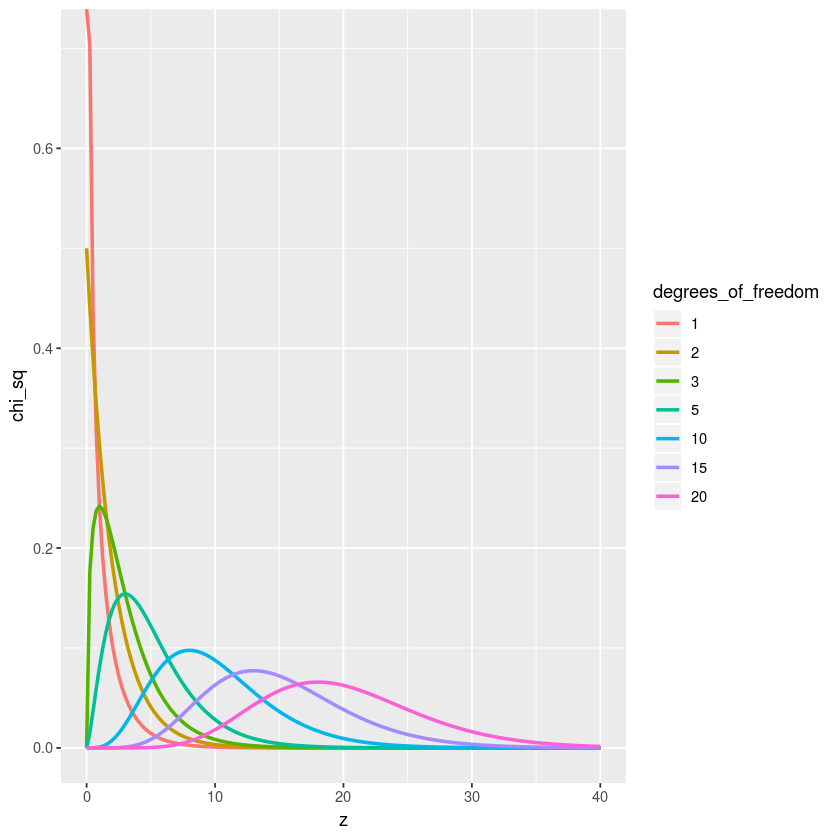

In [9]:
# plot chi-squared graphs
z <- seq(0,100,by=.25)

y <- data.frame(z, chi_sq=dchisq(z,df=1), degrees_of_freedom=1)
y <- rbind(y,  data.frame(z, chi_sq=dchisq(z,df=2),degrees_of_freedom=2))
y <- rbind(y,  data.frame(z, chi_sq=dchisq(z,df=3),degrees_of_freedom=3))
y <- rbind(y,  data.frame(z, chi_sq=dchisq(z,df=5),degrees_of_freedom=5))
y <- rbind(y,  data.frame(z, chi_sq=dchisq(z,df=10),degrees_of_freedom=10))
y <- rbind(y,  data.frame(z, chi_sq=dchisq(z,df=15),degrees_of_freedom=15))
y <- rbind(y,  data.frame(z, chi_sq=dchisq(z,df=20),degrees_of_freedom=20))

y$degrees_of_freedom <- as.factor(y$degrees_of_freedom)

ggplot(y, aes(x=z, y=chi_sq, color=degrees_of_freedom, group=degrees_of_freedom)) +
  geom_line(size=1) +
  scale_x_continuous(limits=c(0,40)) 


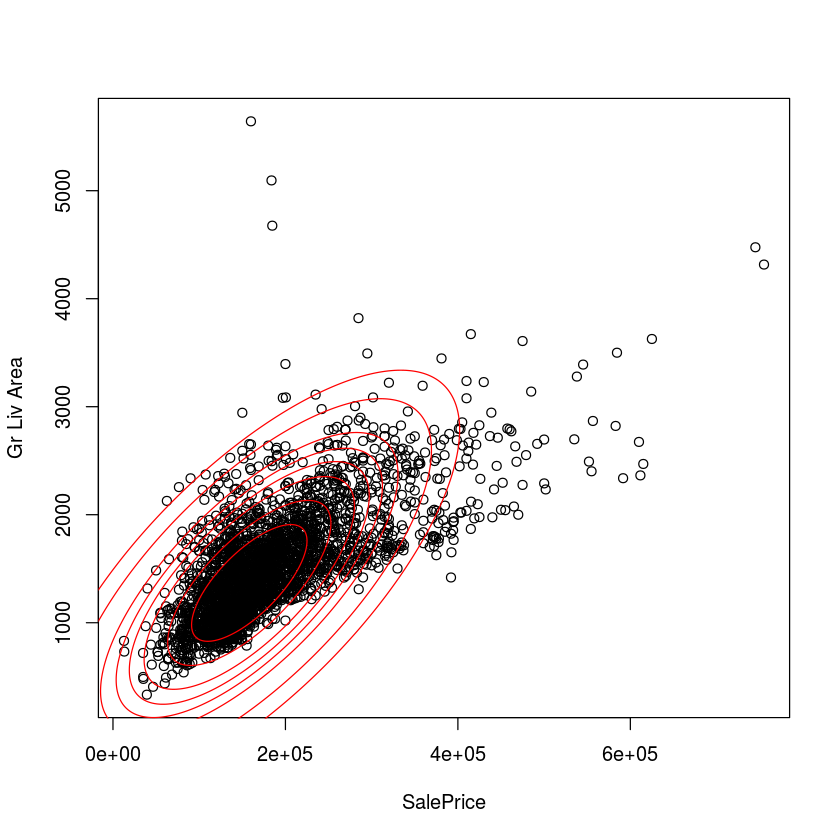

In [10]:
# create covariance matrix to draw Mahalanobis distance plot
num_data <- as.matrix(AmesHousing[,c("SalePrice","Gr Liv Area")])
mcd=covMcd(num_data)

# draw Mahalanobis ellipses, the outer is the higest quantile 
drawMahal(num_data, center=mcd$center, covariance=mcd$cov, 
          quantile = c(0.25, 0.5, 0.75, 0.90, 0.95, 0.975, 0.99, 0.999, 0.9999))

# Calculate Mahalanobis distance
mahal <- mahalanobis(num_data, center=mcd$center, mcd$cov, alpha = quan)

# manually determine outlierts
is_outlier <- (sqrt(mahal) > sqrt(qchisq(0.975,dim(num_data)[2])))

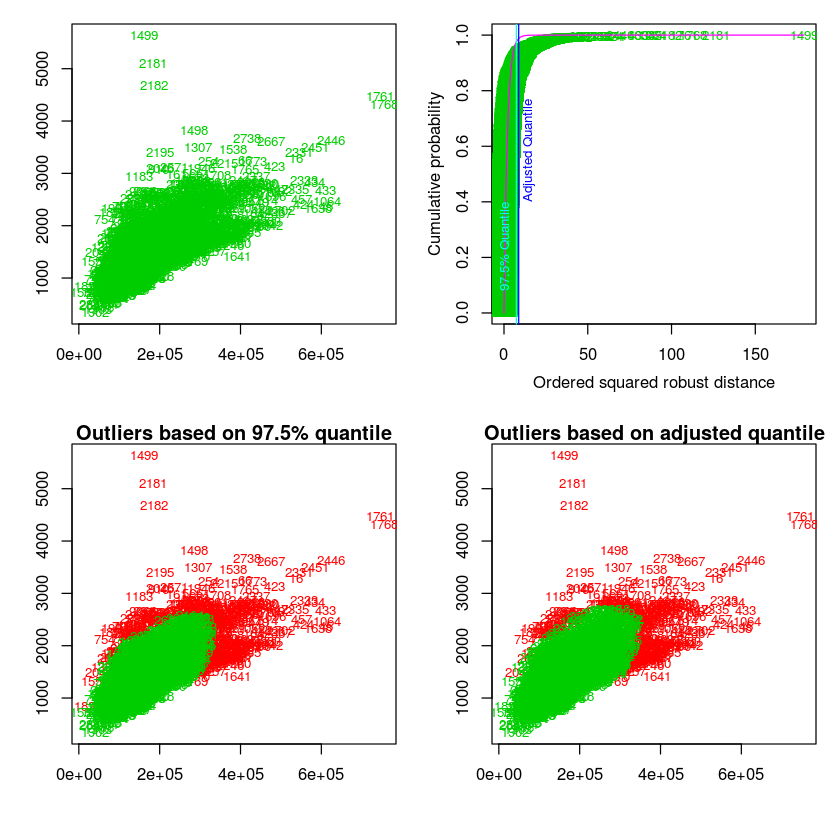

In [11]:
# using package is better, plus we get an adjusted quantile calculation and a nice graph
info <- mvoutlier::aq.plot(data.frame(AmesHousing$SalePrice, AmesHousing$`Gr Liv Area`))

In [12]:
# all outliers
AmesHousing$is_outlier <- info$outliers

#outlier example: one of the biggest "Gr Liv Area"=5642 and smallest "SalePrice"=160000 
sprintf("outlier example: one of the biggest Gr Liv Area=%f and smallest SalePrice=%f", 
                        AmesHousing[1499,c("Gr Liv Area")] , AmesHousing[1499,c("SalePrice")])

#print few additional outliers
print("10 additional outliers")
head(AmesHousing[AmesHousing$is_outlier==TRUE, c("Gr Liv Area", "SalePrice","is_outlier")], 10)

[1] "outlier example: one of the biggest Gr Liv Area=5642.000000 and smallest SalePrice=160000.000000"

[1] "10 additional outliers"


Gr Liv Area,SalePrice,is_outlier
3279,538000,TRUE
1856,394432,TRUE
2334,376162,TRUE
1704,306000,TRUE
1940,395192,TRUE
1544,290941,TRUE
2364,611657,TRUE
2696,500000,TRUE
1752,319900,TRUE
2599,333168,TRUE
